#Partiendo de la limpieza de datos realizada previamente, se utiliza LSTM para predecir la producción de pozos de petroleo.

###Pozos a predecir:
158364, 160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237, 163942





In [1]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_norm_2024-05-27_03:42:59.csv", index_col=0)
dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_clean_2024-05-13_17:08:31.csv", index_col=0)

dataset = dataset[dataset['anio'] >= 2014]

# Seleccionar características relevantes
features = ['prod_pet', 'anio', 'mes', 'idpozo', 'prod_gas', 'prod_agua', 'tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial']

# Filtrar características
data = dataset[features]

# Creacion de una nueva columna 'date' combinando 'anio' y 'mes' para representar la fecha
data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')

data.drop(['mes', 'anio'], axis=1, inplace=True)

# Conversion de la columna 'date' a "datetime type"
data['date'] = pd.to_datetime(data['date'])

# Definicion de un dia de referencia inicial (Es la primera fecha desde la que se filtro previamente).
reference_date = pd.Timestamp('2014-01-01')

# Calculo del numero de meses desde la referencia para cada date.
data['date_numeric'] = (data['date'].dt.year - reference_date.year) * 12 + data['date'].dt.month - reference_date.month + 1

data.drop(['date'], axis=1, inplace=True)

filtered_data_one_id = data[data['idpozo'] == 158364]

filtered_data_one_id.drop(['idpozo'], axis=1, inplace=True)




Mounted at /content/drive


<ipython-input-1-69024501b089>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')
<ipython-input-1-69024501b089>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['mes', 'anio'], axis=1, inplace=True)
<ipython-input-1-69024501b089>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

1/1 [==============================] - 0s 216ms/step

1/1 [==============================] - 0s 326ms/step

1/1 [==============================] - 0s 198ms/step

1/1 [==============================] - 0s 181ms/step

 40%|████      | 4/10 [01:02<01:26, 14.43s/trial, best loss: 19723.206116621677]

1/1 [==============================] - 0s 278ms/step

 50%|█████     | 5/10 [01:24<01:26, 17.32s/trial, best loss: 19723.206116621677]

1/1 [==============================] - 0s 181ms/step

1/1 [==============================] - 0s 175ms/step

1/1 [==============================] - 0s 179ms/step

1/1 [==============================] - 0s 174ms/step

1/1 [==============================] - 0s 174ms/step

100%|██████████| 10/10 [02:33<00:00, 15.32s/trial, best loss: 19723.206116621677]
Mejor tamaño de lote: 16
Mejor cantidad de épocas: 400
Epoch 1/400
4/4 [==============================] - 2s 89ms/step - loss: 0.0719 - val_loss: 0.0071
Epoch 2/400
4/4 [==============================] - 0s 13ms/step - loss: 0.0566 - val_loss: 0.0157
Epoch 3/400
4/4 [==============================] - 0s 13ms/step - loss: 0.0470 - val_loss: 0.0267
Epoch 4/400
4/4 [==============================] - 0s 13ms/step - loss: 0.0408 - val_loss: 0.0345
Epoch 5/400
4/4 [==============================] - 0s 14ms/step - loss: 0.0379 - val_loss: 0.0356
Epoch 6/400
4/4 [==============================] - 0s 25ms/step - loss: 0.0334 - val_loss: 0.0277
Epoch

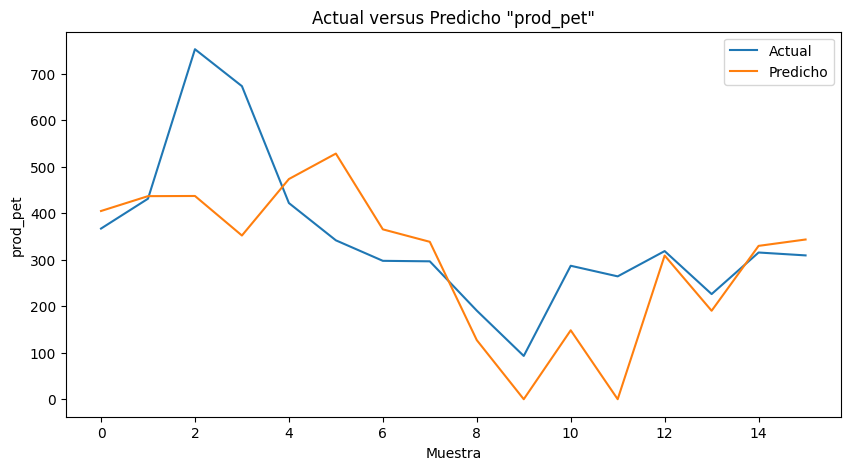

1/1 [==============================] - 0s 21ms/step
Predicciones para valores futuros de prod_pet: [406.9648  376.3145  371.27826 363.62598 356.04282 348.52792]


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_one_id['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_one_id['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_one_id['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())


1/1 [==============================] - 0s 286ms/step

1/1 [==============================] - 0s 208ms/step

1/1 [==============================] - 0s 176ms/step

1/1 [==============================] - 0s 175ms/step

1/1 [==============================] - 0s 186ms/step

1/1 [==============================] - 0s 275ms/step

1/1 [==============================] - 0s 186ms/step

1/1 [==============================] - 0s 175ms/step

1/1 [==============================] - 0s 185ms/step

1/1 [==============================] - 0s 181ms/step

1/1 [==============================] - 0s 185ms/step

1/1 [==============================] - 0s 185ms/step

1/1 [==============================] - 0s 183ms/step

1/1 [==============================] - 0s 198ms/step

1/1 [==============================] - 0s 273ms/step

1/1 [==============================] - 0s 198ms/step

1/1 [==============================] - 0s 181ms/step

1/1 [==============================] - 0s 179ms/step

1/1 [=======================

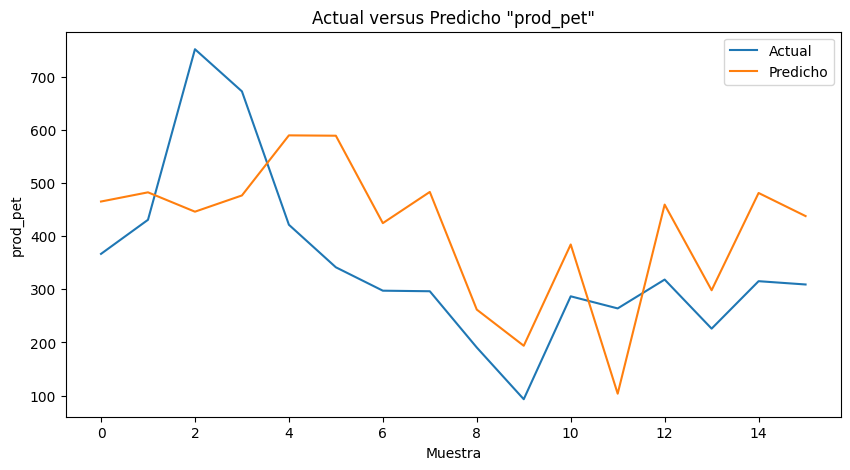

1/1 [==============================] - 0s 20ms/step
Predicciones para valores futuros de prod_pet: [456.59094 451.51477 445.6129  435.9506  426.3912  416.93378]


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf

# Establecer una semilla aleatoria para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, la combinación de MSE y MAE)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Calcular el MSE y MAE
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

    # Combinar MSE y MAE en una única métrica
    combined_metric = 0.5 * mse + 0.5 * mae
    return combined_metric

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)  # Aumentar max_evals

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())
